<a href="https://colab.research.google.com/github/DvoryadkinaDV/Using-neural-networks-to-generate-text/blob/main/OATD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дворядкина Отчет ЛР4

###Импорт библиотек

In [1]:
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from random import sample
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

In [2]:
torch.cuda.is_available()

True

###Загрузим данные

In [3]:
!wget -O poems.txt http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt

--2024-04-18 07:40:13--  http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt
Resolving uit.mpei.ru (uit.mpei.ru)... 193.233.68.149
Connecting to uit.mpei.ru (uit.mpei.ru)|193.233.68.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048627 (1.0M) [text/plain]
Saving to: ‘poems.txt’

poems.txt           100%[===================>]   1.00M  1.22MB/s    in 0.8s    

2024-04-18 07:40:14 (1.22 MB/s) - ‘poems.txt’ saved [1048627/1048627]



In [4]:
# Загружаем текст из файла.
# Стихотворения в файле разделены токеном '</s>'

with open("poems.txt") as file:
  data = file.read().split("</s>\n\n")
print(f"Количество стихов: {len(data)}\n", f"Пример стиха:\n\n{data[10]}",  sep="\n")

Количество стихов: 720

Пример стиха:

Возможно ль? вместо роз, Амуром насажденных,
Тюльпанов гордо наклоненных,
Душистых ландышей, ясминов и лилей,
Которых ты всегда любила
И прежде всякой день носила
На мраморной груди твоей —
Возможно ль, милая Климена,
Какая странная во вкусе перемена!..
Ты любишь обонять не утренний цветок,
А вредную траву зелену,
Искусством превращенну
В пушистый порошок! —
Пускай уже седой профессор Геттингена,
На старой кафедре согнувшися дугой,
Вперив в латинщину глубокой разум свой,
Раскашлявшись, табак толченый
Пихает в длинный нос иссохшею рукой;
Пускай младой драгун усатый
Поутру, сидя у окна,
С остатком утреннего сна,
Из трубки пенковой дым гонит сероватый;
Пускай красавица шестидесяти лет,
У Граций в отпуску, и у любви в отставке,
Которой держится вся прелесть на подставке,
Которой без морщин на теле места нет,
Злословит, молится, зевает
И с верным табаком печали забывает, —
А ты, прелестная!.. но если уж табак
Так нравится тебе – о пыл воображенья! —
Ах

###Подготовка данных и сводные статистики

In [5]:
# Составляем словарь уникальных токенов
vocab = ["PAD", "EOS",] + list(set("".join(data))) #список уникальных символов.

# Формируем два словаря, реализующие перевод символов в их индексы и обратно
id2char = dict(enumerate(vocab)) #словарь индексов в символы
char2id = {char: ind for ind, char in id2char.items()} #словарь символов в индексы
print(f"Количество уникальных символов: {len(vocab)}", id2char, sep="\n")

Количество уникальных символов: 143
{0: 'PAD', 1: 'EOS', 2: 'V', 3: 'н', 4: 'Г', 5: 'T', 6: '"', 7: 'Р', 8: 'x', 9: 'ç', 10: 'Т', 11: 'P', 12: 'e', 13: '(', 14: 'В', 15: "'", 16: 'д', 17: 'y', 18: 'r', 19: 'o', 20: 'f', 21: 'H', 22: '–', 23: 'g', 24: 'Й', 25: '!', 26: '<', 27: 'F', 28: ';', 29: 'Ф', 30: 'ф', 31: ' ', 32: 't', 33: 'S', 34: 'б', 35: 'è', 36: '„', 37: 'â', 38: 'м', 39: 'Л', 40: 'ô', 41: 'l', 42: 'i', 43: 'Ч', 44: 'Ю', 45: 'х', 46: 'М', 47: 'n', 48: 'b', 49: 'ч', 50: 'Э', 51: 'в', 52: 'ъ', 53: 'э', 54: ')', 55: 'А', 56: 'Ш', 57: 'p', 58: 'B', 59: 'U', 60: 'd', 61: 'з', 62: 'к', 63: 'ь', 64: 'Д', 65: 'и', 66: '\xa0', 67: 'j', 68: '?', 69: 'm', 70: 'Щ', 71: 'J', 72: 'п', 73: 'ж', 74: 'ш', 75: 'h', 76: 'К', 77: 'ё', 78: '—', 79: 'u', 80: 'M', 81: '»', 82: 'л', 83: 'v', 84: '*', 85: 'D', 86: 'З', 87: 'г', 88: 's', 89: 'R', 90: '>', 91: 'à', 92: 'O', 93: 'р', 94: 'ц', 95: 'Я', 96: 'И', 97: 'Н', 98: 'о', 99: 'I', 100: 'ю', 101: '\n', 102: 'а', 103: 'У', 104: 'Ж', 105: 'z', 106: 

In [6]:
lengths = list(map(len, data))
print("Максимальная длина текста: ", max(lengths))

Максимальная длина текста:  8948


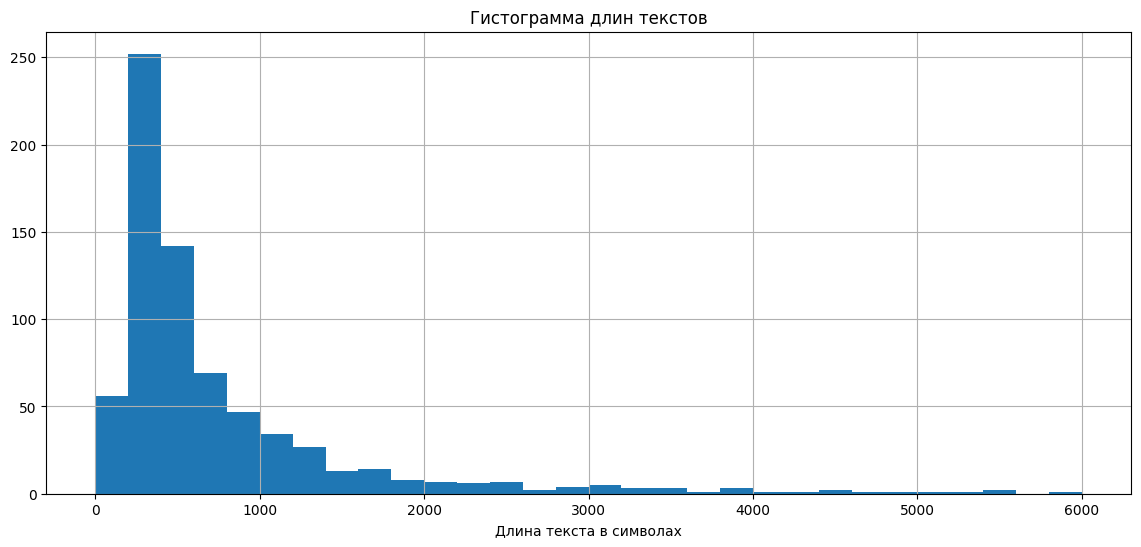

In [7]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.hist(lengths, bins=30, range=[0, 6000])
plt.xlabel("Длина текста в символах")
plt.title("Гистограмма длин текстов")
plt.grid()

In [8]:
lengths = np.array(lengths)
print("Средняя длина", np.mean(lengths))
print("Медиана длины", np.median(lengths))
print("Мода длины", np.bincount(lengths).argmax())

Средняя длина 808.9125
Медиана длины 453.5
Мода длины 221


Где можно будет использовать знание о параметрах распределения длин в выборке?

In [9]:
# Устанавливаем, сколько символов будет генерировать модель (максимальная длина генерируемого текста)
MAXLEN = 500

###Преобразование данных

In [10]:
line_ix = [char2id[c] for c in data[5][:500]]

In [11]:
data_ix = np.zeros([len(data[5]), 500], 'int64')
data_ix[5, :len(line_ix)] = line_ix

In [12]:
data_ix= np.transpose(data_ix)
print(data_ix[5])

[0 0 0 ... 0 0 0]


In [13]:
def to_matrix(data, char2id, max_len=None, dtype='int64', batch_first = True):

    max_len = max_len if max_len else max(map(len, data))
    data = [text[:max_len] for text in data]
    data_ix = np.zeros([len(data), max_len+1], dtype)

    for i in range(len(data)):
        line_ix = [char2id[c] for c in data[i][:max_len]] + [char2id["EOS"]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [14]:
# Проверяем работу функции - кодируем один из текстов и смотрим как он выглядит в кодированном виде
encode = to_matrix(data[:1], char2id, MAXLEN)
print("Исходный текст:\n", data[0])
print("Преобразованный текст:\n", encode[0])

Исходный текст:
 Так и мне узнать случилось,
Что за птица Купидон;
Сердце страстное пленилось;
Признаюсь – и я влюблен!
Пролетело счастья время,
Как, любви не зная бремя,
Я живал да попевал,
Как в театре и на балах,
На гуляньях иль в воксалах
Легким зефиром летал;
Как, смеясь во зло Амуру,
Я писал карикатуру
На любезный женской пол;
Но напрасно я смеялся,
Наконец и сам попался,
Сам, увы! с ума сошел.
Смехи, вольность – всё под лавку
Из Катонов я в отставку,
И теперь я – Селадон!
Миловидной жрицы Тальи
Видел прелести Натальи,
И уж в сердце – Купидон!

Так, Наталья! признаюся,
Я тобою полонен,
В первый раз еще, стыжуся,
В женски прелести влюблен.
Целый день, как ни верчуся
Лишь тобою занят я;
Ночь придет – и лишь тебя
Вижу я в пустом мечтаньи,
Вижу, в легком одеяньи
Будто милая со мной;
Робко, сладостно дыханье,
Белой груди колебанье,
Снег затмивший белизной,
И полуотверсты очи,
Скромный мрак безмолвной ночи —
Дух в восторг приводят мой!..
Я один в беседке с нею,
Вижу… девственну лилею,


**Пояснить, что хранится в переменной encode.**

Переменная encode - вызывает функцию to_matrix для кодирования первого текста из списка data, используя словарь char2id, каждый символ текста заменяется на соответствующий ему числовой индекс из словаря char2id, и длина каждой строки задается максимальной длиной последовательности MAXLEN.


**Как будет выглядеть ваша фамилия в кодированном виде?**

In [15]:
name = 'Dvoryadkina'
encode = to_matrix(name, char2id, 5)
print("Исходный текст:\n", name)
print("Преобразованный текст:\n", encode)

Исходный текст:
 Dvoryadkina
Преобразованный текст:
 [[ 85   1   0   0   0   0]
 [ 83   1   0   0   0   0]
 [ 19   1   0   0   0   0]
 [ 18   1   0   0   0   0]
 [ 17   1   0   0   0   0]
 [120   1   0   0   0   0]
 [ 60   1   0   0   0   0]
 [134   1   0   0   0   0]
 [ 42   1   0   0   0   0]
 [ 47   1   0   0   0   0]
 [120   1   0   0   0   0]]


###Подготовка нейросети

In [16]:
num_embeddings = len(vocab) #количество эмбеддингов должно соответствовать длине словаря
embedding_dim = 32 #определяется размерность эмбеддинга
emb = nn.Embedding(num_embeddings, embedding_dim) # Определяем объект emb как слой эмбеддингов заданного размера

In [17]:
num_embeddings

143

**Почему количество эмбеддингов должно соответствовать длине словаря?**

 Либо будет недостаточно информации для представления всех слов или символов, либо будет избыточная информация, что может привести к переобучению модели. Это связано с тем, что каждый уникальный элемент должен иметь свое собственное представление в пространстве эмбеддингов.

**В качестве примера пропустим через этот слой первые 5 букв первого текста.**

In [18]:
# emb_out - 5 первых символов в виде эмбедингов
emb_out = emb(torch.tensor(encode[0][:5]))
print(f"Размер тензора: {emb_out.shape}\n")
print(emb_out)

Размер тензора: torch.Size([5, 32])

tensor([[ 0.1002,  0.7935,  0.3133, -0.4476,  0.0514, -0.5517, -0.4508, -1.2050,
          0.8082,  0.5026, -0.1521,  0.5414,  1.3278, -0.2600,  0.5115, -0.1955,
         -1.6218, -1.3142, -1.0890, -0.5827,  1.3585, -1.2275,  0.9571,  1.1837,
         -1.0776,  0.9563, -1.5663, -0.1934, -0.2552, -0.5141,  0.4714, -1.0009],
        [ 0.5107,  0.7104, -1.1304, -0.8029, -1.3066,  2.1312, -0.0852,  0.2330,
          0.2069,  0.0565,  1.5922, -0.2661, -1.2324, -0.1144,  1.4216,  0.6076,
          0.2900,  0.5239,  0.3581,  0.1410, -0.8366, -1.4822, -0.2475,  0.2019,
         -0.3391,  2.3931,  1.5239, -0.1627, -0.9418,  0.1005,  0.2718, -1.4765],
        [ 0.9270,  0.0563, -1.2261, -1.6572, -1.3818, -0.6438,  1.5610,  0.8573,
         -1.8048,  0.4159, -0.1240, -0.5083,  1.2732,  0.3260,  2.0373, -1.0383,
         -1.1057,  0.5837,  0.9239, -0.3680,  0.8349, -1.4553, -1.3847,  0.3467,
         -1.1813,  0.7868,  0.1835, -0.8935,  0.5798, -1.3417, -0.1769

**Пояснить, почему получен такой размер emb_out?**

Размер тензора: torch.Size([5, 32]) получается из того, что эмбеддинги применяются к первым пяти буквам из закодированной последовательности encode.  Каждая из пяти букв была преобразована в вектор размерности 32.

###Создадим ячейку GRU

**Обратиться к документации к nn.GRU и ответить на вопрос, за что отвечают параметры input_size, hidden_size, num_layers.**

input_size - количество ожидаемых функций во входных данных

hidden_size - количество объектов в скрытом состоянии

num_layers - количество повторяющихся слоев. Например, num_layers=2 будет означать объединение двух GRU вместе для формирования составного GRU, при этом второй GRU принимает выходные данные первого GRU и вычисляет окончательные результаты. По умолчанию: 1

In [19]:
# Определяем ячейку GRU в переменной gru, предварительно задав рамерность скрытого состояния и количество рекуррентных слоев
input_size = emb.embedding_dim # вход в GRU должен соответствовать размеру эмбеддинга
hidden_size = 60 #<your choice here>
num_layers = 2 #<your choice here>
gru = nn.GRU(input_size, hidden_size, num_layers)
output, h_n = gru(emb_out)
print("Размер output:", output.shape)
print("Размер h_n:", h_n.shape)

Размер output: torch.Size([5, 60])
Размер h_n: torch.Size([2, 60])


In [20]:
in_features = gru.hidden_size
out_features = len(vocab) #предсказываем букву из всего словаря
linear = nn.Linear(in_features, out_features) # Определяем линейный слой. Почему заданы такие входные и выходные параметры для него?
linear_out = linear(output) # output - выход GRU
print("Размер выходного слоя из нейросети: ", linear_out.shape)

Размер выходного слоя из нейросети:  torch.Size([5, 143])


Входные данные для линейного слоя будут иметь размерность, соответствующую размерности скрытого состояния GRU. Это связано с тем, что выходной результат GRU имеет размерность скрытого состояния.



**Что содержится в векторе linear_out?**

**Определить индекс символа, который наиболее вероятно выдаст ячейка GRU на первом шаге?**

In [21]:
linear_out[0]

tensor([-0.0342,  0.0946, -0.0473,  0.0587, -0.1448,  0.1550,  0.0498,  0.0362,
        -0.0179, -0.0500,  0.1082, -0.1278, -0.0490, -0.0204, -0.0082,  0.1164,
         0.0313, -0.0903,  0.1096, -0.1135, -0.0600,  0.0164,  0.1558, -0.0617,
        -0.0417, -0.0961, -0.0746,  0.0485, -0.0239,  0.1478, -0.1253, -0.0771,
        -0.0356, -0.0319,  0.1494,  0.1016,  0.0095,  0.1067, -0.1073,  0.0181,
        -0.0979,  0.0651, -0.1137, -0.0379,  0.0275,  0.0623,  0.0302, -0.0257,
         0.1517, -0.1687, -0.1555,  0.0754,  0.0027, -0.0514,  0.0118,  0.1382,
         0.0816, -0.0655,  0.1487, -0.1137, -0.0095, -0.1731, -0.0124,  0.0677,
        -0.1655, -0.0701, -0.0605, -0.0227, -0.0156,  0.0515,  0.0126, -0.0503,
        -0.0181,  0.1023,  0.0358, -0.0789, -0.0022, -0.0755,  0.0543, -0.0565,
         0.0112, -0.1017,  0.0883,  0.0477,  0.0783, -0.1230,  0.0339, -0.0334,
         0.0674,  0.0545,  0.0677,  0.0406,  0.0318, -0.0004, -0.0456, -0.0711,
         0.0464,  0.0249,  0.0803,  0.06

In [22]:
class CharGRULoop(nn.Module): # Описываем инициализатор класса.
    def __init__(self, num_embeddings=52, embedding_dim=16, hidden_size=60, num_layers=2): # В методе __init__ определим архитектуру модели, создав необходимые слои
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_embeddings)

    def forward(self, x, hid_state): # Здесь описываем структуру сети - как сигнал должен по ней проходить
        x = self.emb(x) # Проходим через эмбеддинг-слой
        if hid_state is not None: # Проходим через GRU, сохраняя hidden state
            h_seq, hid_state = self.gru(x, hid_state)
        else:
            h_seq, hid_state = self.gru(x)
        next_logits = self.hid_to_logits(h_seq) # проходим через полносвязный слой
        next_logp = F.log_softmax(next_logits, dim=-1) # Используем функцию softmax
        return next_logp, hid_state

In [23]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=50, hidden_size=186, num_layers=3)
#<your choice here> Можно попробовать создать сеть с другими значениями параметров

In [24]:
!pip -q install torchinfo

In [25]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         7,150
├─GRU: 1-2                               550,188
├─Linear: 1-3                            26,741
Total params: 584,079
Trainable params: 584,079
Non-trainable params: 0

In [26]:
def generate_sample(model, char2id, id2char, seed_phrase=' ', strategy="greedy", max_length=100, temperature=1.0):
    """
      model - нейросеть
      char2id - словарь преобразования букв в их индексы
      id2char - словарь преобразования индексов в буквы
      seed_phrase - начальная фраза для генерации
      strategy - стратегия генерации (жадная "greedy" или сэмплирование "sample")
      max_length - максимальная длина сгенирированного текста
      temperature - ???
    """

    x_sequence = [char2id[token] for token in seed_phrase] # кодируем начальную фразу
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64) # создаем тензор
    hid_state = None # задаем тензор скрытого состояния h_n, при такой подачи вектор заполнится нулями

    with torch.no_grad(): # отключаем подсчет градиентов, поскольку сеть уже обучена и не нужно проводить обратное распространение ошибки
      for i in range(len(seed_phrase) - 1): # подаем номер буквы и hid_state в цикле
          _, hid_state = model(x_sequence[:, i].unsqueeze(0), hid_state)

      # начинаем генерацию
      for _ in range(max_length - len(seed_phrase)):

          logp_next, hid_state = model(x_sequence[:, -1].unsqueeze(0), hid_state) # подаем последнюю букву из фразы
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0] # нормируем выходы модели на температуру и применяем софтмакс

          if strategy == "greedy": next_ix = p_next.argmax() #берем токен с максимальной вероятностью
          elif strategy == "sample": next_ix = np.random.choice(len(id2char), p=p_next[0]) #получаем следующий токен сэмплированием с вероятностями
          else: raise ValueError('Хулиган, не делай так! Выбери "greedy" или "sample"')

          if id2char[next_ix] == "EOS": break # если получили токен EOS, то прекращаем генерацию
          else:
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64) # создаем тензор следующий буквы
            x_sequence = torch.cat([x_sequence, next_ix], dim=1) # добавляем предсказанный токен в конец последовательности

    return ''.join([id2char[ix] for ix in x_sequence.data.numpy()[0]]) # возвращаем декодированную строку

**Выполните следующую ячейку несколько раз с одной и той же SEED_PHRASE, запомните выводы модели и объясните результат - чем отличается стратегия greedy от sample?**

In [27]:
SEED_PHRASE = 'я люблю сырники!\n' # Ну или что-то другое
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=100))
print()
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=100))

я люблю сырники!
    д::ББББББББББ    ::ééччччTTчыыБББББББ     ::ééччччTTчыыБББББББ     ::ééччччTTчы

я люблю сырники!
ю-M«QНogЭATbèИPADMСnвоH PADдФуQ_цxèо
Sаc


**Greedy** - для выбора следующего символа в тексте выбирается символ с наибольшей вероятностью, предсказанной моделью. Т.о., каждый следующий символ выбирается как наиболее вероятный, основываясь только на предсказаниях модели. Такие тексты короче (т.к. eos имеет высокую вероятность) и проще (больше похожих символов)

**Sample** - для выбора следующего символа используется случайный выбор с учетом вероятностей, предсказанных моделью. Эта стратегия приводит к более разнообразным и менее предсказуемым текстам.

In [28]:
from sklearn.model_selection import train_test_split

batch = 128 # Тексты, для уменьшения накладных расходов, будем подавать на вход модели "батчами" - блоками по 128 документов

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

dataset_train = TensorDataset(torch.tensor(to_matrix(train, char2id, max_len=MAXLEN)))
dataloader_train = DataLoader(dataset_train, batch_size=batch, shuffle=True)

dataset_test = TensorDataset(torch.tensor(to_matrix(test, char2id, max_len=MAXLEN)))
dataloader_test = DataLoader(dataset_test, batch_size=batch, shuffle=False)

In [29]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=256, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss(ignore_index=char2id["PAD"])
# Функция потерь - negative log likelihood loss (NLL Loss) - используеся для задачи многоклассовой классификации в ситуации, когда имеются логарифмы вероятностей каждого класса
# NLL Loss эквивалентен CrossEntropyLoss, но применяется к логарифмам вероятностей - у нас на выходе линейного слоя как раз исопользуется функция softmax

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,152
├─GRU: 1-2                               1,036,800
├─Linear: 1-3                            36,751
Total params: 1,082,703
Trainable params: 1,082,703
Non-trainable params: 0

In [30]:
train[:1]

['Буря мглою небо кроет,\nВихри снежные крутя:\nТо, как зверь, она завоет,\nТо заплачет, как дитя,\nТо по кровле обветшалой\nВдруг соломой зашумит,\nТо, как путник запоздалый,\nК нам в окошко застучит.\n\nНаша ветхая лачужка\nИ печальна, и темна.\nЧто же ты, моя старушка,\nПриумолкла у окна?\nИли бури завываньем\nТы, мой друг, утомлена,\nИли дремлешь под жужжаньем\nСвоего веретена?\n\nВыпьем, добрая подружка\nБедной юности моей,\nВыпьем с горя; где же кружка?\nСердцу будет веселей.\nСпой мне песню, как синица\nТихо за морем жила;\nСпой мне песню, как девица\nЗа водой поутру шла.\n\nБуря мглою небо кроет,\nВихри снежные крутя;\nТо, как зверь, она завоет.\nТо заплачет, как дитя.\nВыпьем, добрая подружка\nБедной юности моей,\nВыпьем с горя; где же кружка?\nСердцу будет веселей.\n\n']

In [31]:
example = torch.tensor(to_matrix(train[:1], char2id, max_len=MAXLEN)) # Возьмем первый документ и попробуем сгененировать этот же текст начиная с первой буквы

train_example = example[:, :-1]
target_example = example[:, 1:]

next_logp, hid_state = model(train_example, hid_state=None)

print('perplexity: ', torch.exp(loss_fn(next_logp.permute(0, 2, 1), target_example)).item())

perplexity:  142.2803497314453


In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()

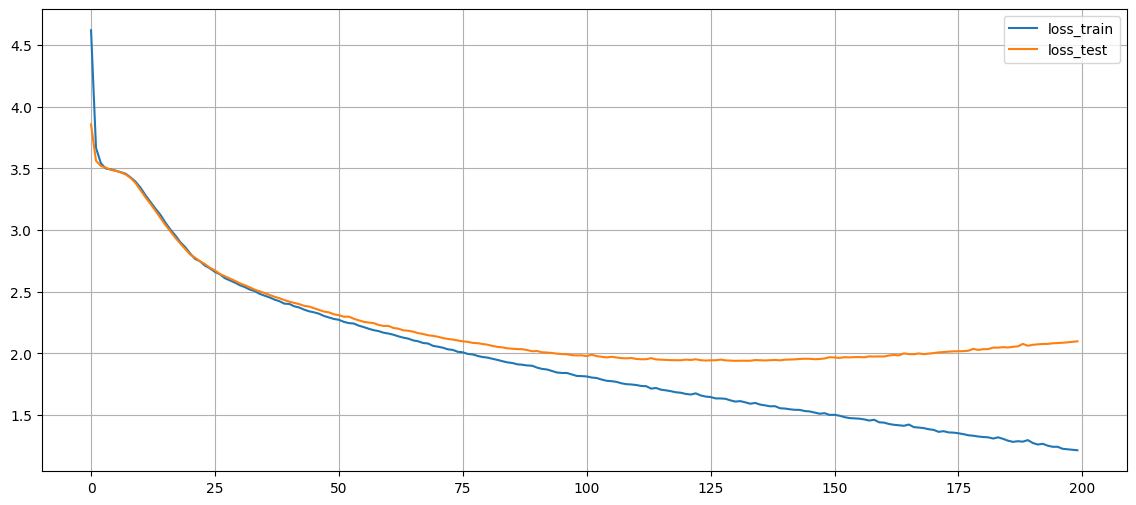

In [33]:
EPOCH = 200 # количество эпох обучения
history_train = [] # список значений лосса трейна на каждой эпохи
history_test = [] # список значений лосса теста на каждой эпохи
model.to(device) # И модель, и данные должны находиться на одном устройстве.
                 # Поэтому при работе с GPU нужно следить и явно указывать, на каком устройстве проводится работа.


best_test_loss = float("inf")
for i in range(EPOCH): #цикл по эпохам

  loss_test = 0
  loss_train = 0

  for batch in dataloader_train: #цикл по тренировачным батчам

    optimizer.zero_grad() #обнуляем градиенты
    batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device) #делаем из батча тензор

    predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None) #подаем батч в модель

    actual_next_tokens = batch_ix[:, 1:] # таргеры

    loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long()) # считаем лосс на батче
    loss_train += loss.item() # добавляем лосс с батча в суммарный лосс

    loss.backward() # делаем обратный проход
    optimizer.step() # делаем шаг оптимизатором

  history_train.append(loss_train/len(dataloader_train)) # добавляем  средний лосс за эпоху в список

  for batch in dataloader_test: #цикл по тестовым батчам
    with torch.no_grad(): # отключаем подсчет градиентов

      batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device)
      predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None)

      actual_next_tokens = batch_ix[:, 1:]

      loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long())
      loss_test += loss.item()

  loss_test = loss_test/len(dataloader_test)
  history_test.append(loss_test)

  if loss_test < best_test_loss: #сохраняем лучшую модель по лоссу на тесте
    best_test_loss = loss_test
    best_model = copy.deepcopy(model)
    best_model.to("cpu")

  if (i + 1) % 5 == 0: # выводим график лосса каждые 5 эпох
    clear_output(True)
    plt.plot(history_train, label='loss_train')
    plt.plot(history_test, label='loss_test')
    plt.grid()
    plt.legend()
    plt.show()

**Достаточно ли обучилась модель? Имеет ли смысл изменить количество эпох обучения?**


In [34]:
print("perplexity (best model test): ", np.exp(best_test_loss))
print("perplexity (last epoch test): ", np.exp(loss_test))

perplexity (best model test):  6.955433139433273
perplexity (last epoch test):  8.148374779777996


In [35]:
device = 'cpu' # Обучение обычно проводится на GPU, но чтобы не тратить его ресурсы, работу по генерации текста уже обученной моделью стоит перенести обратно на CPU
model.to(device)

CharGRULoop(
  (emb): Embedding(143, 64)
  (gru): GRU(64, 256, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=143, bias=True)
)

In [36]:
#Если вы не согласны, вы можете поменять стартовую фразу, но что думает об этом высказывание машина?
SEED_PHRASE = 'Я люблю сырники,'

In [37]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=MAXLEN))

Я люблю сырники, бег арас.
Качами, Судьба ей чел гонит Мистов.
Она мне ночь не стордный презнен, где снов
Не охот


In [38]:
prompt = "Время спать уже"
print(generate_sample(model, char2id, id2char, seed_phrase=prompt, strategy="sample", max_length=256))

Время спать уже резвыка,
Не видишь мне Камена
Отрадой и минуть.
Смытый состер нешежд —
Нет от мира благослушно,
И, еще ни за, не утра,
И длянули лубка Мо
Водокно, его свободы,
Я любезный росква —
И пенистым Варшегах,
И постыдва природе


In [39]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=MAXLEN))

Я люблю сырники, не славный страстный,
На поле сладостной посторожной,
И с тобой постигно в приходит на стеснить,
И не страшный полей не смеет в ней волны
И сердце страстной страстной и пристрастный,
И сладостной страстной без ней в ней волной,
И с тобой последний и признаюсь и страхой.




In [40]:
print(generate_sample(model, char2id, id2char, seed_phrase=prompt, strategy="greedy", max_length=256))

Время спать уже теперь толпой,
Как бы простой и вас наслажденье
В тебе пред ним страсти и видал.
Послушайте мне с каменьем порогу
Под сенью прекрасно без ним,
Как в последний свою вашем,
Не послушайте внимать души,
В полемлет с вами со мною,
И сердце ваша 


###Эксперименты с температурой

In [41]:
nice_strategy = "sample" #<your choice here>

In [42]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=2.0))

Я люблю сырники, о,
mифпоковче юнны
Яозые: вбледЮрКрумымшВ…и.
СласнГе папипшики лещет,



In [43]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=0.5))

Я люблю сырники, он с порой не славный,
Ты не последний порой стройный,
Когда души, не под тубительный,
Скажи мне веселое бестрет.
Открывал с насталом собой,
Какое с пристань сонной страстной
Сидел поле в нем город полемую,
И грустно весной лирой томной,
Ты разбирал на постре мой поэт,
Но не под ним не расстами не расстрой.




**Сделайте выводы как влияет изменение температуры на генерацию текста.**

Чем ниже температура, тем больший смысл имеет текст, но при этом уменьшается разнообразие используемых слов.

**Выберите оптимальное значение температуры**

0,5 показывает достаточно понятный текст

In [44]:
# По завершению работы с рекуррентной сетью, очистим кэш
torch.cuda.empty_cache()

###Bonus track GPT

In [45]:
!pip install -q transformers[torch]

In [46]:
import locale
import torch
import transformers
import numpy as np

from warnings import simplefilter
from IPython.display import clear_output
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import TextDataset, DataCollatorForLanguageModeling

In [47]:
#  Задаем некоторые настроечные параметры касательно кодировки и отображения предупреждений
locale.getpreferredencoding = lambda: "UTF-8"
simplefilter("ignore", category=FutureWarning)
transformers.logging.set_verbosity_error()

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"  # Опередлим, какой моделью будем пользоваться
tokenizer = GPT2Tokenizer.from_pretrained(model_name)  # Определим токенайзер для нашего текста
model = GPT2LMHeadModel.from_pretrained(model_name).to(device) # Загрузим предобученную модель трансформера rugpt3small от Сбера

clear_output()

In [49]:
SEED_PHRASE = 'Машинное обучение - это'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
out = model.generate(input_ids, do_sample=False, max_length=20)

generated_text = list(map(tokenizer.decode, out))[0]

print(generated_text) #Так работает предобученный трансформер

Машинное обучение - это не только обучение, но и развитие.  В этом случае обучение может


In [50]:
train_path = "train_dataset.txt"

with open("poems.txt", encoding="utf-8") as file:
  data = file.read().split("</s>\n\n")

with open(train_path, mode="w", encoding="utf-8") as f:
    f.write("".join(data))

In [51]:
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=128) # Создание датасета
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) # Создание даталодера (нарезает текст на оптимальные по длине куски)

In [52]:
torch.cuda.is_available()

True

In [53]:
!pip install accelerate -U

In [54]:
!pip install transformers==4.24.0

In [55]:
training_args = TrainingArguments(
    output_dir="./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=10,                    # рекомендованные значения (warmup_steps нужен для "разогрева" сети, c его помощью learning rate постепенно увеличивается до заданного значения)
    gradient_accumulation_steps=16,     # рекомендованные значения
)
#(обычно мы хотим положить батч по-больше, чтобы сеть побыстрей сошлась, но мы ограничены памятью gpu, gradient_accumulation_steps накапливает (суммирует или усредняет) градиенты за прогон на 16 батчах )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5), # рекомендованные значения
        None,
    ),
)

In [56]:
output = trainer.train() # Дообучаем трансформер на наши тексты

***** Running training *****
  Num examples = 1487
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 16
  Total optimization steps = 30
  Number of trainable parameters = 125231616


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 759.4557, 'train_samples_per_second': 29.37, 'train_steps_per_second': 0.04, 'train_loss': 5.8349970499674475, 'epoch': 14.68}


In [57]:
print('perplexity: ', np.exp(output.training_loss)) #расчет перплексии

perplexity:  342.063724949662


Какое значение перплексии получилось у трансформера? 342

Какое значение перплексии получалось у рекуррентной сети?

Почему у рекуррентной сети значение было существенно ниже, но качество текстов хуже? Почему нельзя сравнивать значения для рекуррентной сети и трансформера?

In [58]:
SEED_PHRASE = 'Пришла весна, а значит'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True, # sample strategy
        temperature=1.3,
        max_length=256,
        pad_token_id=512 # указываем id <PAD> токена
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Пришла весна, а значит, не лето..." (с) 
 "Идти, или, на закате,
Вплавь, и плыть по Оке,
Над волнами, или в облаках". 

Но вот настало вечер воскресенья. И на пристань я гляну: 

"Будь у меня на часах минутка. 
 "Иду к тебе. Ты у капища. 
 Сей человек и есть я!.." 

Я, брат Иван, к тебе пристану. 
 "Долго ль я, мой Иван, медленный медлюсь?" 
 Прими меня мой брат Иван. 

 "Умолкни, Иуда! — Ты, муж родной. 
 Каких ласк лишься? 
 Друзья ль ты? Где? Чем я тебя лечу? 

Не плачь, а послушай вникни: в реке плавающей 
 Пошла я под парус.
 Лезет парус по волнам, плывет навстречу
 Мощная барка, тащатся волны..." 

О! Как это трудно: ждать минуту. 
 Хочешь ли ты, друг милый, ждать, что будет? 

Я


Проверьте работу ячейки выше для разных стартовых фраз и разных параметров temperature, max_length, do_sample и объясните, за что отвечает каждый из параметров. Подберите (субъективно) лучшие

###Beam Search

In [59]:
SEED_PHRASE = 'Чтобы приготовить'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True,
        max_new_tokens=75,
        no_repeat_ngram_size=3, # устанавливает вероятность 0 для повторяющихся n-gram (таким образом решается проблема зацикливания)
        pad_token_id=512,
        num_beams=5,
        num_return_sequences=5,  # количество возвращенных сгенерированных текстов отранжированных по вероятности после beam_search
        top_p=0.8, #<your choice here>
        top_k=20, #<your choice here>
        temperature=2.0 #<your choice here>
    )

generated_text = list(map(tokenizer.decode, out))

In [60]:
# Выведем _num_return_sequences_ сгенерированных текстов
for i, seq in enumerate(generated_text):
  print(f"Applicant {i}", seq, "\n", sep="\n")

Applicant 0
Чтобы приготовить вкусное блюдо?
Подавать ли на ужин?
Сладко ли тебе, милый мой друг?
Я люблю тебя и не знаю, что с тобой!
Ты, мой милый друг, не знаешь,
Как я счастлив, не ведаю,
Что ты со мною, и как мне больно!
Я не хочу тебя огорчать;
Но


Applicant 1
Чтобы приготовить,
Вкусное, вкусное
Мягкое и вкусненькое.

Желаю тебе,
Твой милый друг,
Нежной, нежной любви!
Подари мне
Счастливое мгновенье,
Счастье и покой.
Прости, что так долго
Ты не был рядом.
Я тебя люблю, милый друг


Applicant 2
Чтобы приготовить? – спросил я.

– Не знаю, – отвечал он. – А ты не знаешь, что такое любовь?

Я сказал:

«Любишь ли ты меня, брат?»
И он мне отвечал:
"Люблю ли я тебя?
Люблю ль я тебя, брат?"

И я сказал:


Applicant 3
Чтобы приготовить?
Вкусно ли тебе?
Иль не сладка ли сладость,
Что в сердце твоем?

Скучно ли, сладко ль?
Ступай в дом свой,
Смотри, смотри
На свет, на звезды;
Скажи: "Благословен Бог мой,
Будь милостив к нам,



Applicant 4
Чтобы приготовить вкусную выпечку 



Для теста

1

In [62]:
torch.save(model, "gpt2_finetune.torch")
mod = torch.load("gpt2_finetune.torch")